[Go to last cell](#bottom_cell)
<a id='top_cell'></a>

# Cluster Analysis of the 2014 Boston Marathon

In [1]:
##### Code toggle #####
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is hidden by default for easier reading.
Toggle <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mpcol
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 500)

In [3]:
# Import the data
df = pd.read_csv('BostonMar2014.csv')

In [4]:
# Aesthetics
palettes = {}

palettes['gender'] = {0:'#c5c2f4', 1:'#e57068'} # gender
palettes['wave'] = sns.cubehelix_palette(6, start=2, reverse=True) #wave
palettes['country'] = sns.color_palette('Set1').as_hex() # nationalities
palettes['clusters'] = sns.color_palette("bright", 5) # clusters

<hr>

# 1) Investigating the raw data & feature engineering

In [5]:
# Likely some embedded strings where there should only be numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


### __'name'__ and __'age'__ are self-explanatory. I've engineered age bracket for the sake of a more useful visualization.
> The Boston marathon divides its qualifying times into 5 year age brackets, so those are the buckets I'll use for feature engineering and visualization.
<br><br>
<i>For more information, see: https://www.baa.org/races/boston-marathon/enter/qualify/history-qualifying-times</i>

In [6]:
# Define age brackets
age_definitions = {'18-39':(18,39),
                   '40-44':(40,44),
                   '45-49':(45,49),
                   '50-54':(50,54),
                   '55-59':(55,59),
                   '60-64':(60,64),
                   '65-69':(65,69),
                   '70-74':(70,74),
                   '75-79':(75,79),
                   '80+':(80,84)}

# Add the color palette for age
palettes['age'] = sns.cubehelix_palette(len(age_definitions), reverse=True)

# Define a function to convert ages to brackets
def convert_age(x):    
    for key in age_definitions: 
        if age_definitions[key][0] <= x <= age_definitions[key][1]:
            return key               
    else: 
        print('Could not bucket age for value {}'.format(x))
        return np.nan

# Create a column for age bracket
df['age_bracket'] = df['age'].apply(lambda x: convert_age(x))

### There is some string formatting (dirty data) in the distance checkpoints; clean it up

In [7]:
# These are the timepoints along the route, some have dirty data
checkpoints = '5k 10k 20k half 25k 30k 35k 40k'.split()
for point in checkpoints:
    df[point] = df[point].str.replace('-','0.0').astype(float)           # drop these string entries
    df[point] = df[point].astype(float)
    
# This column was already clean, now tack it on
checkpoints.append('official')

### __'division'__ represents an individual's position within their division – division itself isn't included in the raw data, but could perhaps be approximated with clustering. Participants from 23 divisions finished the race. 

In [8]:
print('Participants from {} divisions finished the race.'.format(df['division'].value_counts()[:1].sum()))

Participants from 23 divisions finished the race.


### Engineer __'gender'__ into a binary feature
This makes it more useful. __'genderdiv'__ represents an individual's finishing position in their gender division.

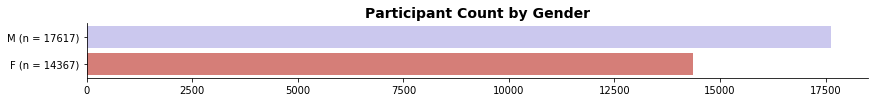

In [9]:
# Define the y labels for the visualization
labels = ['{} (n = {})'.format(gender, df[df['gender'] == gender].shape[0]) for gender in df['gender'].unique()]

# Change gender to a binary variable
df = pd.get_dummies(df, columns=['gender'])

# Plot the figure
plt.figure(figsize=(14,1))
sns.countplot(y=df['gender_F'], palette=palettes['gender'])
sns.despine()
plt.title('Participant Count by Gender', {'fontsize':14, 'fontweight':'bold'})
plt.xlabel('')
plt.ylabel('')
plt.yticks([0,1], labels)
plt.show()

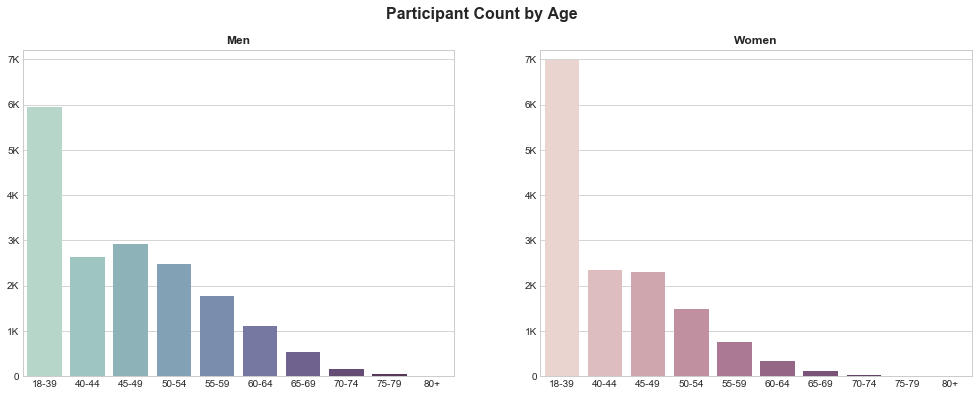

In [10]:
# formatting function to represent numbers in the thousands as '4K' or similar
def thousands(y, pos):
    if y >= 1000:
        return '{:1.0f}K'.format(y*1e-3)
    else:
        return 0

# This customizes the tick labels, using function above
formatter = FuncFormatter(thousands)

plt.style.use('seaborn-whitegrid')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17,6))
fig.suptitle('Participant Count by Age', fontweight='bold', fontsize=16)

men = df[df['gender_M'] == 1]['age_bracket']
women = df[df['gender_F'] == 1]['age_bracket']
frames = [men, women]
labels = ['Men', 'Women']

# Create a palette for each
palettes['men'] = sns.cubehelix_palette(len(age_definitions), start=1, rot=-0.75, light=0.8, dark=0.2)
palettes['women'] = sns.cubehelix_palette(len(age_definitions))

# Create two countplots separated by sex
for idx, ax in enumerate([ax0, ax1]):   
    sns.countplot(frames[idx], ax=ax,
                  order=age_definitions.keys(),
                  label=labels[idx],
                  palette=palettes[labels[idx].lower()])
    ax.set(ylim=(0,7200), ylabel='', xlabel='')
    ax.set_title(labels[idx], fontweight='bold')
    ax.yaxis.set_major_formatter(formatter)

# The object-oriented way to do plt.show()
fig.canvas.draw_idle()

### __'bib'__ is the number printed on a participant's bib. It contains information about a participant's start wave.
> Bib numbers indicate what wave of the race the participant was assigned to, and, accordingly, what time of day 
they began the race. Participants whose bib began with F were assigned to the women's elite wave, while participants whose bib began with W were assigned to the men's elite wave.
<br><br><i>For more information, refer to: http://registration.baa.org/2014/cf/Public/iframe_EntryLists.cfm</i>

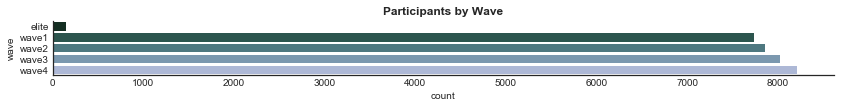

In [11]:
wave_definitions = {'elite':(0,100),
                    'wave1':(101,8999),
                    'wave2':(9000,17999),
                    'wave3':(18000,26999),
                    'wave4':(27000, 40000)}

# Function converting bibs to waves
def convert_bib(x):    
    try:
        for key in wave_definitions:
            if wave_definitions[key][0] <= float(x) <= wave_definitions[key][1]: return key             
    except ValueError:   
        if 'W' in str(x): return 'elite'
        elif 'F' in str(x): return 'elite'    
    else: 
        print(float(x))
        return np.nan

# Create a wave column
df['wave'] = df['bib'].apply(lambda x: convert_bib(x))

plt.style.use('seaborn-white')
plt.figure(figsize=(14,1))
sns.countplot(y=df['wave'], palette=palettes['wave'])
sns.despine()
plt.title('Participants by Wave', {'fontweight':'bold'})
plt.show()

###  __'country'__ and __'state'__: Where are participants from?

In [12]:
print('Unique countries: {}\n{}'.format(len(df['country'].unique()), df['country'].unique()))
print('\nUnique states: {}\n{}'.format(len(df['state'].unique()), df['state'].unique()))

Unique countries: 78
['JPN' 'KEN' 'RSA' 'ETH' 'SUI' 'USA' 'FRA' 'CAN' 'ESP' 'POL' 'RUS' 'BLR'
 'MAR' 'UKR' 'BRA' 'THA' 'CHN' 'ITA' 'GER' 'GBR' 'AUS' 'SWE' 'GRE' 'SLO'
 'IRL' 'KOR' 'ARG' 'COL' 'NED' 'ISR' 'CZE' 'NOR' 'AUT' 'CRC' 'MEX' 'GUA'
 'SIN' 'DEN' 'HUN' 'BEL' 'FIN' 'CHI' 'ISL' 'VEN' 'DOM' 'PER' 'HKG' 'SVK'
 'NZL' 'TPE' 'PHI' 'CAY' 'POR' 'UAE' 'IND' 'PAN' 'ROU' 'LUX' 'ESA' 'TRI'
 'MAS' 'VGB' 'EGY' 'BRN' 'EST' 'ECU' 'LIE' 'TUR' 'BOL' 'BAR' 'URU' 'QAT'
 'INA' 'BER' 'TAN' 'BAH' 'CRO' 'ZIM']

Unique states: 69
[nan 'CA' 'ON' 'MI' 'QC' 'IL' 'OR' 'AZ' 'CO' 'VA' 'GA' 'NJ' 'ME' 'MA' 'UT'
 'NY' 'MO' 'RI' 'NH' 'MT' 'KY' 'FL' 'TN' 'AB' 'WA' 'WI' 'DC' 'PA' 'OH'
 'IN' 'NS' 'MD' 'IA' 'MN' 'CT' 'SD' 'TX' 'DE' 'LA' 'NC' 'OK' 'NV' 'AL'
 'KS' 'NE' 'MB' 'HI' 'AK' 'NM' 'BC' 'VT' 'ID' 'SC' 'WV' 'PE' 'ND' 'MS'
 'AR' 'SK' 'NT' 'PR' 'WY' 'NB' 'YT' 'NL' 'AE' 'AA' 'AP' 'GU']


###  __'pace'__ is derived from __'official'__, and describes a participant's pace over the course of the race in mph. To validate this assumption, I derived __'distance'__ by multiplying __'pace'__ by __'official'__, then mean and standard deviation against the expected ~26.22 mile distance of the Boston Marathon.

In [13]:
df['distance'] = round(df['official'] / df['pace'],2)
print('Mean distance: {}\n'.format(round(df['distance'].mean(),2)) +
      'Standard deviation: {}'.format(round(df['distance'].std(),2)))

Mean distance: 26.2
Standard deviation: 0.05


<hr>

# 2) Relationships between demographics & checkpoint completion time

### Checkpoint completion time by gender

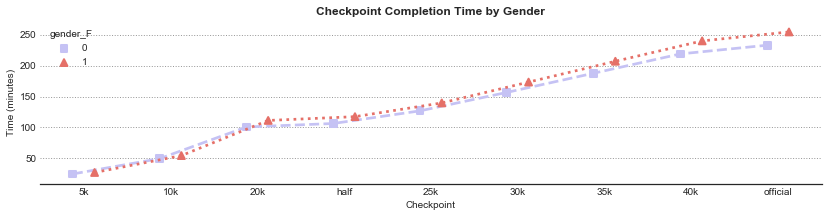

In [14]:
stacked_checkpoints = pd.melt(df,
                              value_vars=checkpoints,
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['gender_F'])

plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='gender_F',
            markers=[',','^'],
            linestyles=['--', ':'],
            palette=palettes['gender'],
            ci=95,
            orient="v",
            dodge=0.25)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint Completion Time by Gender', {'fontweight':'bold'})
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [15]:
# Print some descriptive statistics to provide further information
f_n = df[df['gender_F'] == 1]['official'].shape[0]
f_avg = round(df[df['gender_F'] == 1]['official'].mean(),2)
f_std = round(df[df['gender_F'] == 1]['official'].std(),2)

print('Of the {} female participants in the Boston Marathon,\naverage finishing time was:'
      ' {} minutes (standard deviation = {})'.format(f_n, f_avg, f_std))

m_n = df[df['gender_F'] == 0]['official'].shape[0]
m_avg = round(df[df['gender_F'] == 0]['official'].mean(),2)
m_std = round(df[df['gender_F'] == 0]['official'].std(),2)

print('\nOf the {} male participants in the Boston Marathon,\naverage finishing time was:'
      ' {} minutes (standard deviation = {})'.format(m_n, m_avg, m_std))

Of the 14367 female participants in the Boston Marathon,
average finishing time was: 254.83 minutes (standard deviation = 48.42)

Of the 17617 male participants in the Boston Marathon,
average finishing time was: 233.34 minutes (standard deviation = 53.36)


### Checkpoint completion time by country
> Participants from 78 countries were represented in the 2014 Boston Marathon, but only the United States, Canada, Great Britain, Italy, and Mexico had over 200 representatives. For the sake of the visualization's clarity, I've only included those 5 countries.

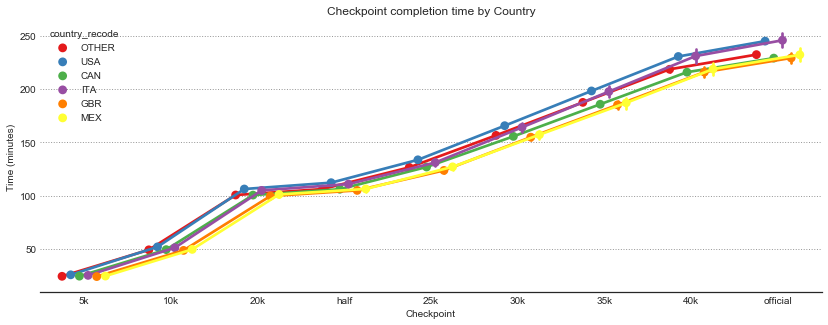

In [33]:
countries = 'USA CAN ITA GBR MEX'.split()

# Aggregate countries with fewer than 200 racers as 'other country' in a recoded column.
other_countries = df['country'].value_counts().index.tolist()[5:]
df['country_recode'] = df['country'].apply(lambda x: np.where(x in other_countries, 'OTHER', x))

# Make the completion times tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=checkpoints,
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['country_recode'])

# Plot the figure
plt.figure(figsize=(14,5))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='country_recode',
            hue_order=countries.append('OTHER'),
            palette=palettes['country'],
            ci=95,
            orient="v",
            dodge=0.5)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint completion time by Country')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [17]:
# Define a function to streamline descriptive statistic retrieval
def get_descriptives(column, category):
    c_n = df[df[column] == category]['official'].shape[0]
    c_avg = round(df[df[column] == category]['official'].mean(),2)
    c_std = round(df[df[column] == category]['official'].std(),2)    
    print('There were {} {} participants in the 2014 Boston Marathon.\nOn average, they finished the race in'
          ' {} minutes (standard deviation = {})\n'.format(c_n, category, c_avg, c_std))    

# Print some descriptive statistics to provide further information
countries.remove('OTHER')
for country in countries:
    get_descriptives('country', country)

There were 27233 USA participants in the 2014 Boston Marathon.
On average, they finished the race in 245.05 minutes (standard deviation = 53.11)

There were 2175 CAN participants in the 2014 Boston Marathon.
On average, they finished the race in 229.12 minutes (standard deviation = 39.4)

There were 212 ITA participants in the 2014 Boston Marathon.
On average, they finished the race in 245.84 minutes (standard deviation = 49.5)

There were 346 GBR participants in the 2014 Boston Marathon.
On average, they finished the race in 229.23 minutes (standard deviation = 47.31)

There were 205 MEX participants in the 2014 Boston Marathon.
On average, they finished the race in 232.24 minutes (standard deviation = 44.78)



### Checkpoint completion time by wave: 

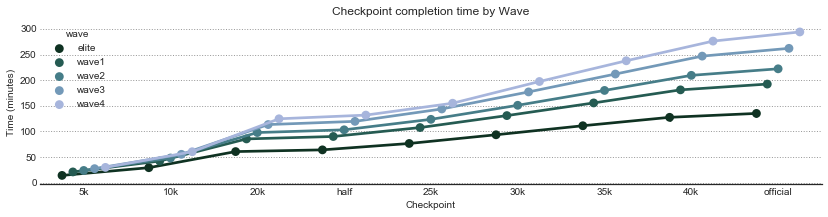

In [18]:
# Make the checkpoint completion times tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=checkpoints,
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['wave'])

# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='wave',
            palette=palettes['wave'],
            ci=95,
            orient="v",
            dodge=0.5)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint completion time by Wave')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [19]:
# Print some descriptive statistics to provide further information
for wave in df['wave'].unique():
    get_descriptives('wave', wave)

There were 147 elite participants in the 2014 Boston Marathon.
On average, they finished the race in 135.2 minutes (standard deviation = 29.25)

There were 7741 wave1 participants in the 2014 Boston Marathon.
On average, they finished the race in 192.37 minutes (standard deviation = 22.52)

There were 7860 wave2 participants in the 2014 Boston Marathon.
On average, they finished the race in 222.16 minutes (standard deviation = 23.31)

There were 8028 wave3 participants in the 2014 Boston Marathon.
On average, they finished the race in 262.05 minutes (standard deviation = 39.93)

There were 8208 wave4 participants in the 2014 Boston Marathon.
On average, they finished the race in 293.99 minutes (standard deviation = 45.71)



### Checkpoint completion time by age bracket

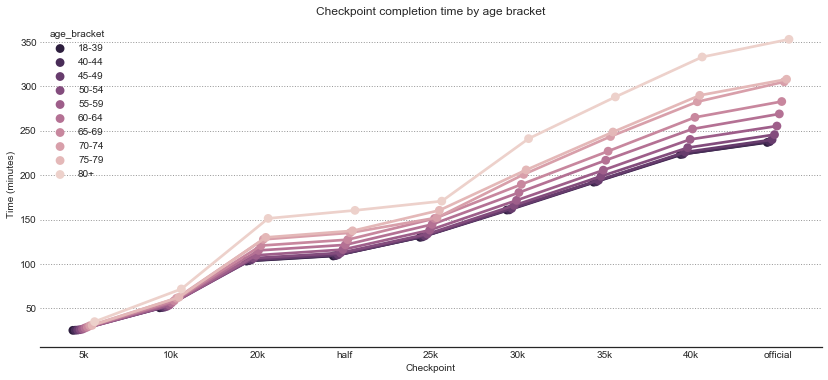

In [20]:
# Make the age brackets tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=checkpoints,
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['age_bracket'])

# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,6))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='age_bracket',
            hue_order=list(age_definitions.keys()),
            palette=palettes['age'],
            ci=None,
            orient="v",
            dodge=0.25)

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Checkpoint completion time by age bracket')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

Participants in each age bracket performed, on average, better than the participants in the next-oldest age bracket and worse than participants in the next-youngest age bracket. However, this distinction is much less pronounced between participants under 50 years of age.

<hr>

### Here is a look at split times, or how fast a runner completes their first vs. second half.  Very few are able to run an even or negative split (running the second half faster than the first).

<Figure size 1152x576 with 0 Axes>

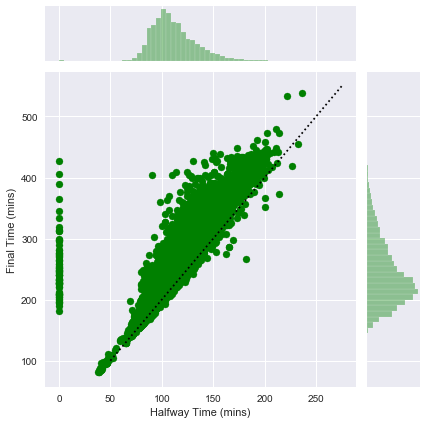

In [37]:
plt.figure(figsize=(16, 8))

with sns.axes_style('darkgrid'):
    g = sns.jointplot('half', 'official', df, kind='scatter', color='g')
    g.ax_joint.plot(np.linspace(50, 275), np.linspace(100, 550), ':k')
    g.set_axis_labels('Halfway Time (mins)', 'Final Time (mins)');
    
plt.show()

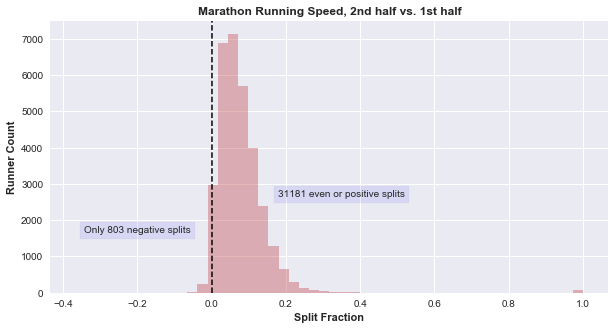

In [35]:
# Let's see the degree to which someone splits the race: create a new column
df['split_frac'] = 1 - 2*df['half'] / df['official']

# calculate negative / positive split counts and messages
negs = df[df['split_frac'] < 0]['split_frac'].count()
neg_message = 'Only ' + str(negs) + ' negative splits'
pos_message = str(df['split_frac'].shape[0] - negs) + ' even or positive splits'

# plot, and draw a zero / even split line
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(df['split_frac'], kde=False, color='C2')
plt.axvline(0, color='k', linestyle='--', lw=1.5)

# text boxes with messages, other labels
plt.text(-0.2, 1650, neg_message, ha='center', bbox=dict(facecolor='blue', alpha=0.08))
plt.text(0.35, 2650, pos_message, ha='center', bbox=dict(facecolor='blue', alpha=0.08))
plt.xlabel('Split Fraction', fontweight='bold')
plt.ylabel('Runner Count', fontweight='bold')
plt.title('Marathon Running Speed, 2nd half vs. 1st half', fontweight='bold')

plt.show()

<hr>

# 3) Modeling

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Finalizing features, rescaling

In [24]:
# Create a new dataframe for features
features = pd.DataFrame()

# Rescale age from 0-1.
features['age'] = df['age']
features['is_female'] = df['gender_F']
features['overall'] = df['overall']
features['division'] = df['division']
features['genderdiv'] = df['genderdiv']

# Add countries with over 200 participants as binary columns.
countries.append('OTHER')
for country in countries:
    features[country] = np.where(df['country'] == country, 1, 0)
    
# Add waves as binary columns.
for wave in df['wave'].unique():
    features[wave] = np.where(df['wave'] == wave, 1, 0)

# Add checkpoint times.
for col in checkpoints:
    features[col] = df[col]
    
features.head(n=3)

,age,is_female,overall,division,genderdiv,USA,CAN,ITA,GBR,MEX,OTHER,elite,wave1,wave2,wave3,wave4,5k,10k,20k,half,25k,30k,35k,40k,official
0,47,0,8,8,8,0,0,0,0,0,0,1,0,0,0,0,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25
1,33,1,21,1,1,0,0,0,0,0,0,1,0,0,0,0,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95
2,41,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60


### Normalizing the data to account for differences in scale between my features

In [25]:
X = features

# Normalize the data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_normed = pd.DataFrame(np_scaled, columns=list(features))
X_normed.head(n=3)

,age,is_female,overall,division,genderdiv,USA,CAN,ITA,GBR,MEX,OTHER,elite,wave1,wave2,wave3,wave4,5k,10k,20k,half,25k,30k,35k,40k,official
0,0.460317,0.0,0.000219,0.001003,0.000398,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.092237,0.154565,0.167818,0.167829,0.164937,0.157235,0.158903,0.158218,0.010147
1,0.238095,1.0,0.000626,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.186544,0.289909,0.293425,0.293531,0.285205,0.263909,0.258986,0.259860,0.127324
2,0.365079,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.089132,0.147891,0.160909,0.160688,0.158467,0.149981,0.150046,0.149700,0.000000


### Performing PCA for graphing purposes

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normed)
pca_1 = [x[0] for x in X_pca]
pca_2 = [x[1] for x in X_pca]

X_pca

array([[ 0.91630293, -0.04239324],
       [ 0.43514148, -0.5669596 ],
       [ 0.92615298, -0.04207286],
       ...,
       [-0.91795314,  0.37234912],
       [-1.02401914,  0.41025456],
       [-0.23802152,  0.76732535]])

### I'm utilizing mean shift clustering for my first pass at this data – spectral & affinity propagation are too expensive for a dataset of this size, and K means won't work because (1) I don't know K, and (2) I don't know whether or not the clusters are globular.

In [27]:
### Mean Shift
bandwidth = estimate_bandwidth(X_normed, 
                               quantile=0.2, 
                               n_samples=500, 
                               n_jobs=1)
# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_normed)
ms_labels = ms.predict(X_normed)

ms

MeanShift(bandwidth=1.3323390819961933, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=None, seeds=None)

### Visualizing the clusters

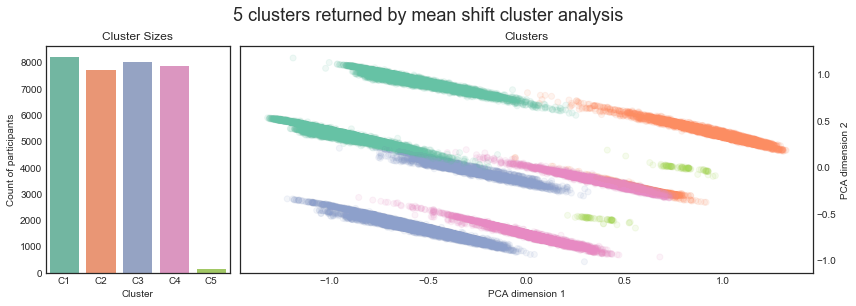

In [28]:
# Add the clusters to the dataframes
features['cluster'] = ms_labels + 1
df['cluster'] = ms_labels + 1

palettes['clust_rgb'] = sns.color_palette('Set2', 5).as_hex()
palettes['clust_cmap'] = mpcol.ListedColormap(palettes['clust_rgb'], name='my_name')

plt.figure(figsize=(12,4))
gs = GridSpec(1, 8)

# Create a plot that'll do double duty by labeling the clusters by color & describing their sizes
ax1 = plt.subplot(gs[0, 0:2])    
sns.countplot(x=features['cluster'],
              palette=sns.color_palette(palettes['clust_rgb']))

plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Count of participants')
cluster_labels = ['C{}'.format(x) for x in range(1,6)]
ax1.set_xticklabels(cluster_labels)

# Visualize the blobs
ax2 = plt.subplot(gs[0, 2:])    
plt.scatter(x=pca_1,
            y=pca_2,
            c=features['cluster'],
            cmap=palettes['clust_cmap'],
            alpha=0.1)
plt.title('Clusters')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")


plt.suptitle('{} clusters returned by mean shift cluster analysis'.format(len(set(ms_labels))), fontsize=18, y=1.05)

plt.tight_layout()
plt.show()

### Without ground truth, evaluate using silhouette coefficients

In [29]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_normed,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

from sklearn import metrics
from sklearn.metrics import pairwise_distances

counter = 0
for sample in [X1, X2, X3, X4]:
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
    labels = model.labels_
    counter += 1
    print('Silhouette coefficient for sample {}: {}'.format(counter,
                                                            round(metrics.silhouette_score(sample,
                                                                                           labels,
                                                                                           metric='euclidean'),4)))

Silhouette coefficient for sample 1: 0.4697
Silhouette coefficient for sample 2: 0.4739
Silhouette coefficient for sample 3: 0.4696
Silhouette coefficient for sample 4: 0.4702


> These scores are pretty consistent across the splits - my model is consistently producing clusters with points that are closer to each other than they are to other datapoints. This feels like solid ground.

<hr>

# 4) Cluster Summaries

## Demographics

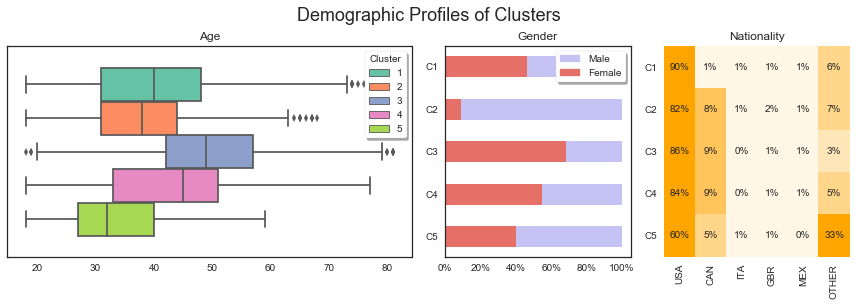

In [48]:
# Summarize demographics by cluster
fig = plt.figure(figsize=(12,4))
gs = GridSpec(1, 4)

# Age
features['y'] = 1          # Add a dummy column for plotting in-place

plt.style.use('seaborn-white')
ax1 = plt.subplot(gs[0, 0:2])    
sns.boxplot(y='y',
            x='age',
            data=features,
            hue='cluster',
            palette=sns.color_palette(palettes['clust_rgb']),
            orient='h',
            saturation=1)

ax1.axes.get_yaxis().set_visible(False)

plt.title('Age')
plt.xlabel('')
plt.legend(loc="upper right", title='Cluster',
           frameon=True, fancybox=True, shadow=True)

# Gender
ax2 = plt.subplot(gs[0, 2:3])
for cluster in np.arange(6):
    f_percent = features[features['cluster'] == cluster]['is_female'].mean()
    m_percent = 1 - features[features['cluster'] == cluster]['is_female'].mean()
    f_std = features[features['cluster'] == cluster]['is_female'].std()
    m_std = 1 - features[features['cluster'] == cluster]['is_female'].std()    
    
    p1 = plt.barh(cluster, f_percent, 0.5, color=palettes['gender'][1])
    p2 = plt.barh(cluster, m_percent, 0.5, left=f_percent, color=palettes['gender'][0])

plt.gca().invert_yaxis()
ax2.set_yticklabels([''] + cluster_labels)
ax2.set_xticklabels(['{}%'.format(tick) for tick in np.arange(0,120,20)])

gender_legend = [mpatches.Patch(color=palettes['gender'][0], label='Male'),
                 mpatches.Patch(color=palettes['gender'][1], label='Female')]
plt.legend(handles=gender_legend, loc="upper right",
           frameon=True, fancybox=True, shadow=True)
plt.title('Gender')

# Nationality
ctry_data = {}
for cluster in np.arange(1,6):
    ctry_data[cluster] = [(df[(df['cluster'] == cluster) & (df['country_recode'] == country)]['country_recode'].count())
                          /df[df['cluster'] == cluster].shape[0] for country in countries]
# Visualize the data
ax3 = plt.subplot(gs[0, 3:4])
sns.heatmap(pd.DataFrame(ctry_data, index=countries).transpose(), 
                 annot=True,
                 fmt=".0%",
                 cmap=sns.light_palette("orange"),
                 cbar=False,
                 vmin=0, 
                 vmax=0.15)

plt.yticks(rotation=0) 
cluster_labels = ['C{}'.format(x) for x in range(1,6)]
ax3.set_yticklabels(cluster_labels)

plt.title('Nationality')

# Define overall aesthetics and plot.
plt.suptitle('Demographic Profiles of Clusters',fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

## Performance

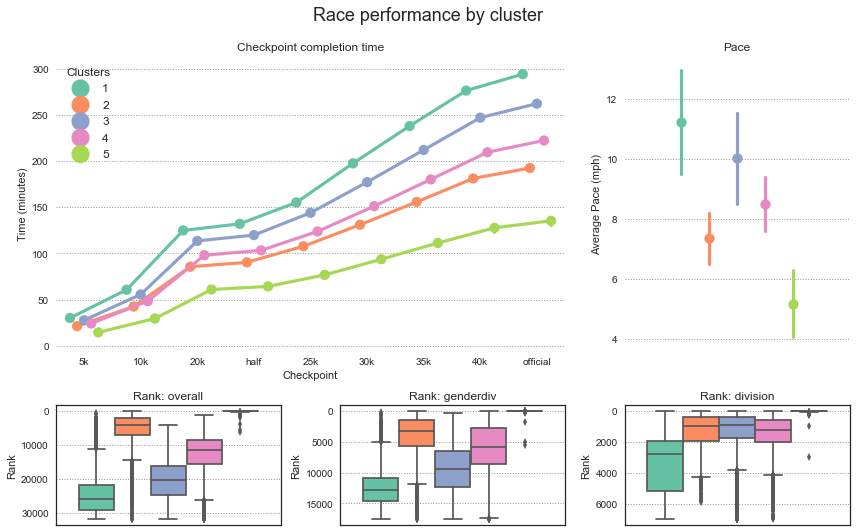

In [47]:
# Plot a figure summarizing race performance across clusters
gs = GridSpec(3, 3)
plt.figure(figsize=(12,7))

# Checkpoints
# Tidy the data for easier visualization.
stacked_checkpoints = pd.melt(df,
                              value_vars=checkpoints,
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['cluster'])

# Visualize checkpoint completion time by wave
ax1 = plt.subplot(gs[0:2, 0:2])    
sns.pointplot(data=stacked_checkpoints,
              x='checkpoint',
              y='time',
              hue='cluster',
              palette=sns.color_palette(palettes['clust_rgb']),
              ci=95,
              orient="v",
              dodge=0.5)

sns.despine(left=True)
ax1.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

plt.title('Checkpoint completion time')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

lg = ax1.legend(title='Clusters', markerscale=2, fontsize=12)
title = lg.get_title()
title.set_fontsize(12)

# Pace
df['y'] = features['y'] # Add a dummy column for plotting in-place.
ax2 = plt.subplot(gs[0:2, 2]) # Place the plot on the grid
sns.pointplot(x='y',
              y='pace',
              hue='cluster',
              data=df,
              ci='sd',
              palette=sns.color_palette(palettes['clust_rgb']),
              dodge=0.5)

ax2.legend_.remove()
ax2.set_xticklabels('')
ax2.axes.get_xaxis().set_visible(False)

sns.despine(left=True, bottom=True)
ax2.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

plt.ylabel('Average Pace (mph)')
plt.title('Pace')


# Rankings
# Tidy the data for easier visualization.
stacked_divisions = pd.melt(df,
                            value_vars=['overall', 'division', 'genderdiv'],
                            var_name='division',
                            value_name='rank',
                            id_vars=['cluster'])

stacked_divisions['y'] = 1                   # Add a dummy column for plotting in-place.
for idx, division in enumerate(['overall', 'genderdiv', 'division']):
    ax3 = plt.subplot(gs[2, idx:idx+1])    

    sns.boxplot(x='y',
                y='rank',
                data=stacked_divisions[stacked_divisions['division'] == division],
                hue='cluster',
                palette=sns.color_palette(palettes['clust_rgb']),
                orient='v',
                saturation=1)
    
    ax3.legend_.remove()
    ax3.set_xticklabels('')
    ax3.axes.get_xaxis().set_visible(False)
    plt.ylabel('')
    
    ax3.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
    
    plt.gca().invert_yaxis()         # Invert the plot so that higher ranks appear near the top.
    plt.title('Rank: {}'.format(division))
    plt.ylabel('Rank')
    
# Name and show the overall plot.
plt.suptitle('Race performance by cluster',fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

<hr>

# 5) Profiles

## 🛀 Cluster 1: 'The Casuals' 
In general, participants from cluster 1 ranked 2,000 or lower in their division, finished the race with an overall pace of ~11 mph, lean slightly male, and are almost entirely American (~90%). Almost 100% of them started the race in Wave 4.

## 🏃‍ Cluster 2: 'The Fitness Bros'
Participants from cluster 2 rank very well overall, in their gender divisions, and in their divisions. They are overwhelmingly male, less American than any cluster except 5 (82%), and all started the race in Wave 1. These participants are serious athletes, though not necessarily word-class.

## 👵 Cluster 3: 'The Boomers'
Participants from cluster 3 perform well in their divisions, but not in overall rankings. They lean female relative to the other clusters, and and are older than other typical participants. They all started the race in Wave 3.

## 💪 Cluster 4: 'Strong Performers'
Participants from cluster 4 rank extremely well in their divisions and third only to clusters 5 and 2 in overall. They lean slightly female and averaged a pace of 8.4 mph. 

## 🏆 Cluster 5: 'The Professionals'
Participants from Cluster 5 comprise the very highest rankings, lean male, and are much more international than any other cluster: only ~60% are American. Their average pace was approximately 5 mph. These are world-class runners who come from all over to participate in the Marathon.

[Back to top](#top_cell)
<a id='bottom_cell'></a>